In [1]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import joblib

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/contribDB_2014_final.csv")

In [ ]:
df.head()

,full_name,sum,count
0,Anderson Nate,304.5,15
1,Antipolo Aurora,5.0,1
2,Baird Thomas,600.0,2
3,Balaban Stephen,1024.0,1
4,Bean Jennifer,55.0,2


In [ ]:
vectorizer = joblib.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/pt_vec_fullname.joblib')


In [ ]:
max_name = 47
all_categories =  ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
n_categories = len(all_categories)

vocab = list(vectorizer.get_feature_names_out())
all_letters = ''.join(vocab)
n_letters = len(vocab)
oob = n_letters + 1
vocab_size = oob + 1

In [ ]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, df.columns.get_loc('full_name')]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [ ]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    if len(line) > max_name:
      line = line[:max_name]
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [ ]:
dataset = EthniColorDataset(df, lineToTensor)

In [ ]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Anderson Nate tensor([ 3., 42., 32., 33., 46., 47., 43., 42.,  0., 16., 29., 48., 33., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
1 Antipolo Aurora tensor([ 3., 42., 48., 37., 44., 43., 40., 43.,  0.,  3., 49., 46., 43., 46.,
        29., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
2 Baird Thomas tensor([ 4., 29., 37., 46., 32.,  0., 22., 36., 43., 41., 29., 47., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])


In [ ]:
import os

batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 47])
1 1024 torch.Size([1024, 47])
2 1024 torch.Size([1024, 47])


In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/lstm_fullname.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 1969/1969 [00:56<00:00, 35.10it/s]


In [ ]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [ ]:
results_df.head()

,names,predictions
0,Pershing Robert,3
1,Murray Kelly,3
2,Pharris Jerry,3
3,Liles Jackie,3
4,Tull Barbara,3


In [ ]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [ ]:
results_df.head()

,names,predictions,preds
0,Pershing Robert,3,nh_white
1,Murray Kelly,3,nh_white
2,Pharris Jerry,3,nh_white
3,Liles Jackie,3,nh_white
4,Tull Barbara,3,nh_white


In [ ]:
results_df.shape

(2016256, 3)

In [ ]:
results_df['preds'].value_counts()

nh_white    1706583
nh_black     134691
hispanic     101059
asian         70986
other          2937
Name: preds, dtype: int64

In [ ]:
res_dict = results_df['preds'].value_counts().to_dict()

<Axes: >

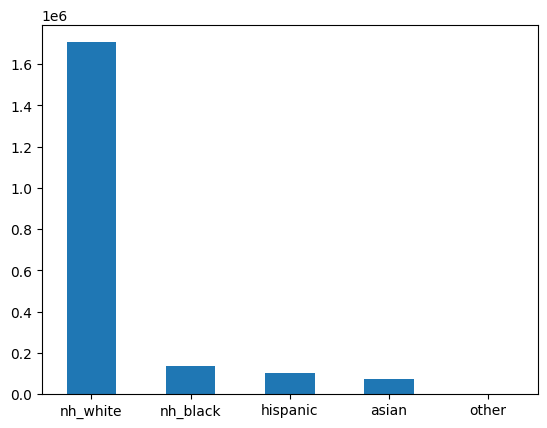

In [ ]:
results_df['preds'].value_counts().plot.bar(x='lab', y='val', rot=0)

In [ ]:
results_df.shape[0]

2016256

In [ ]:
res_dict

{'nh_white': 1706583,
 'nh_black': 134691,
 'hispanic': 101059,
 'asian': 70986,
 'other': 2937}

In [ ]:
for x in res_dict:
  print(f"{x} - {round(res_dict[x]/results_df.shape[0], 3)}%")

nh_white - 0.846%
nh_black - 0.067%
hispanic - 0.05%
asian - 0.035%
other - 0.001%


In [ ]:
final_df = pd.merge(df, results_df, left_on=['full_name'], right_on=['names'], how='left')

In [9]:
df.groupby('preds')['sum'].sum()/df['sum'].sum()


preds
asian       0.033532
hispanic    0.025996
nh_black    0.044247
nh_white    0.895400
other       0.000694
Name: sum, dtype: float64

<Axes: xlabel='preds'>

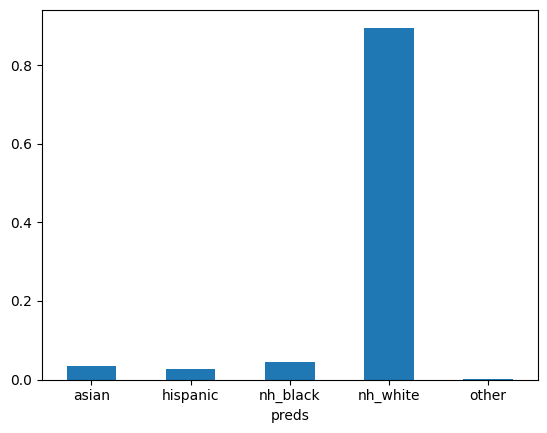

In [10]:
(df.groupby('preds')['sum'].sum()/df['sum'].sum()).plot.bar(x='lab', y='val', rot=0)

In [ ]:
final_df[['full_name', 'sum', 'count', 'predictions', 'preds']].to_csv("/content/drive/MyDrive/Colab/ethnicolor/data/dime_contrib_2014_results.csv", index=False)
